# Introduction

We are looking to create a predictive model that can classify what type of hand you have given 5 cards and their respective suit.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Google Drive mount

This will mount the Google drive to colab


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Here assuming the all data of poker from https://github.com/bhaskar-debug/poker/tree/main is copied in google drive inside `MyDrive/poker`


In [3]:
root = "/content/drive/MyDrive/poker/content"
data_path = f"{root}/data"

# Step 1

Step one with any data is to import it.

Below we have the statement that is importing the data which is of file extension ".data". Please note that the program is reading line by line and therefore must make appropriate type conversions.


In [4]:
root = "content"
data_path = f"{root}/data"

In [5]:
df_hands_train = pd.read_csv(
    f"{data_path}/raw/poker-hand-training-true.data",
    names=["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand Rank"],
)
df_hands_train.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand Rank
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


#### TODO:// I have used small dataset above to train, please uncomment the following below to train with larger datasets.


In [6]:
# TODO:// Uncomment this to use the 100M dataset

# df_hands_train = pd.read_csv(
#     f"{data_path}/raw/poker100m",
#     names=["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand Rank"],
# )
# df_hands_train.head()

In [7]:
df_hands_test = pd.read_csv(
    f"{data_path}/raw/poker-hand-testing.data",
    names=["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand Rank"],
)
df_hands_test.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand Rank
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


# Step 2


We take that DataFrame and we split it into the training data.

- X_train is all the lines except the classification of the hand.
- Y_train is the given hand classification.


In [8]:
X_train = df_hands_train.iloc[:, :-1].reset_index(drop=True)
y_train = df_hands_train.iloc[:, -1]
X_train.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,1,10,1,11,1,13,1,12,1,1
1,2,11,2,13,2,10,2,12,2,1
2,3,12,3,11,3,13,3,10,3,1
3,4,10,4,11,4,1,4,13,4,12
4,4,1,4,13,4,12,4,11,4,10


We must repeat the same process for the testing data in order to make it usable


In [9]:
X_test = df_hands_test.iloc[:, :-1].reset_index(drop=True)
y_test = df_hands_test.iloc[:, -1]
X_test.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,1,1,1,13,2,4,2,3,1,12
1,3,12,3,2,3,11,4,5,2,5
2,1,9,4,6,1,4,3,2,3,9
3,1,4,3,13,2,13,2,1,3,6
4,3,10,2,7,1,2,2,11,4,9


# Step 3

Vizualize the key features of the data.


Hand Rank
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: Hand Rank, dtype: int64


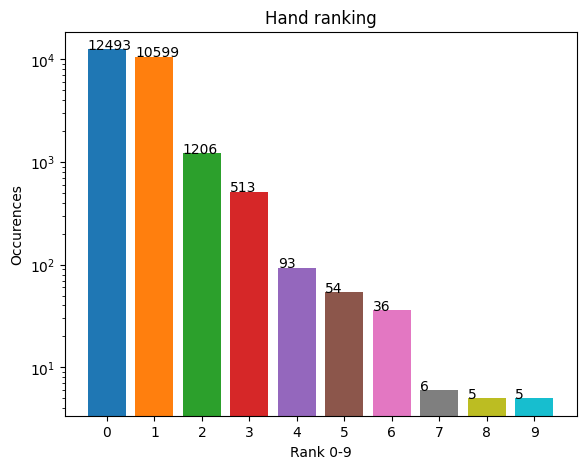

           prob_hand
Hand Rank           
0              49.95
1              42.37
2               4.82
3               2.05
4               0.37
5               0.21
6               0.14
7               0.02
8               0.01
9               0.01


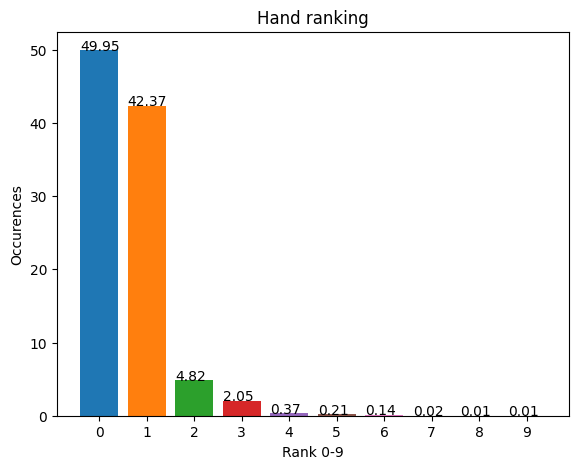

In [10]:
# vizualize the distribution of the possible hands in the train data.
print(y_train.groupby(y_train).size())
y = y_train.groupby(y_train).size()
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_title("Hand ranking")
ax.set_xlabel("Rank 0-9")
ax.set_ylabel("Occurences")
ax.set_yscale("log")
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
for val in range(len(y)):
    ax.annotate(str(y[val]), xy=(val, y[val]), xytext=(val - 0.4, y[val]))
    ax.bar(val, y[val])
plt.show()
hands = y.sum()
s = pd.DataFrame()
s["prob_hand"] = y.apply(lambda x: (x * 10000 // hands) / 100)
print(s)
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_title("Hand ranking")
ax.set_xlabel("Rank 0-9")
ax.set_ylabel("Occurences")
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
for val in range(len(s)):
    ax.annotate(
        str(s.iloc[val, 0]),
        xy=(val, s.iloc[val, 0]),
        xytext=(val - 0.4, s.iloc[val, 0]),
    )
    ax.bar(val, s.iloc[val, 0])
plt.show()

I found it interesting to explore the relationship between the occurrences and the probabilities of each possible hands. As you can see by the data, the majority of hand you will play during a session of poker are worth nothing. If you happen to have a pair, you can develop an appropriate betting strategy in order to see if you are able to cover anyone. Be concerned that although you have a relatively common hand, someone will always have a hand better than yours. If you happen to have a two pair and both cards of the pair are not found in the community cards. You have a relatively strong hand compared to others. The odds of being beat by a set exist, but as shown, it is relatively low compared to other hands. Good luck getting anything else, the odds for the rest are very low.

One thing to take into account, I did not create this data set and does not reflect probabilities during actual games. Just what is being observed based on the generated set. Although, these probabilities are useful for this task. Considering you are dealt a hand of 5.


# Step 4

Deciding on the proper model to use

Given the data, we know we will be using a classification model. I have chosen to compare the results between many model. It is always a good idea to test the score from several models in order to see which works best.


In [11]:
def get_model_log(model, xtrain, ytrain, xtest, ytest):
    model.fit(xtrain, ytrain)

    y_pred = model.predict(xtest)
    model_log = pd.DataFrame(columns=["Accuracy", "F1", "Precision", "Recall"])
    model_log.loc[0, "Accuracy"] = accuracy_score(ytest, y_pred)
    model_log.loc[0, "F1"] = f1_score(ytest, y_pred, average="weighted")
    model_log.loc[0, "Precision"] = precision_score(ytest, y_pred, average="weighted")
    model_log.loc[0, "Recall"] = recall_score(ytest, y_pred, average="weighted")

    return model_log

# Step 5

## Using normal data without preprocessed for classification

- To learn about the Decision Tree model and Random Forest model goto: https://scikit-learn.org/stable/supervised_learning.html
- To learn about the XGBoost model: https://xgboost.readthedocs.io/en/stable/


NOTE: This step will take some time to complete. Please be patient and check after some time.


In [12]:
dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, criterion="gini")
dt_log = get_model_log(dt, X_train, y_train, X_test, y_test)
dt_log

,Accuracy,F1,Precision,Recall
0,0.479245,0.482997,0.486958,0.479245


In [13]:
xgb = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=6)
xgb_log = get_model_log(xgb, X_train, y_train, X_test, y_test)
xgb_log

,Accuracy,F1,Precision,Recall
0,0.735433,0.709173,0.709149,0.735433


In [14]:
rf = RandomForestClassifier(n_estimators=100, criterion="gini")
rf_log = get_model_log(rf, X_train, y_train, X_test, y_test)
rf_log

,Accuracy,F1,Precision,Recall
0,0.614654,0.582664,0.5931,0.614654


In [15]:
result_df = pd.DataFrame(
    {
        "Model": ["DT", "XGB", "RF"],
        "Accuracy": [
            dt_log["Accuracy"].mean(),
            xgb_log["Accuracy"].mean(),
            rf_log["Accuracy"].mean(),
        ],
        "F1": [
            dt_log["F1"].mean(),
            xgb_log["F1"].mean(),
            rf_log["F1"].mean(),
        ],
        "Precision": [
            dt_log["Precision"].mean(),
            xgb_log["Precision"].mean(),
            rf_log["Precision"].mean(),
        ],
        "Recall": [
            dt_log["Recall"].mean(),
            xgb_log["Recall"].mean(),
            rf_log["Recall"].mean(),
        ],
    }
)

result_df.head(8)

,Model,Accuracy,F1,Precision,Recall
0,DT,0.479245,0.482997,0.486958,0.479245
1,XGB,0.735433,0.709173,0.709149,0.735433
2,RF,0.614654,0.582664,0.593100,0.614654


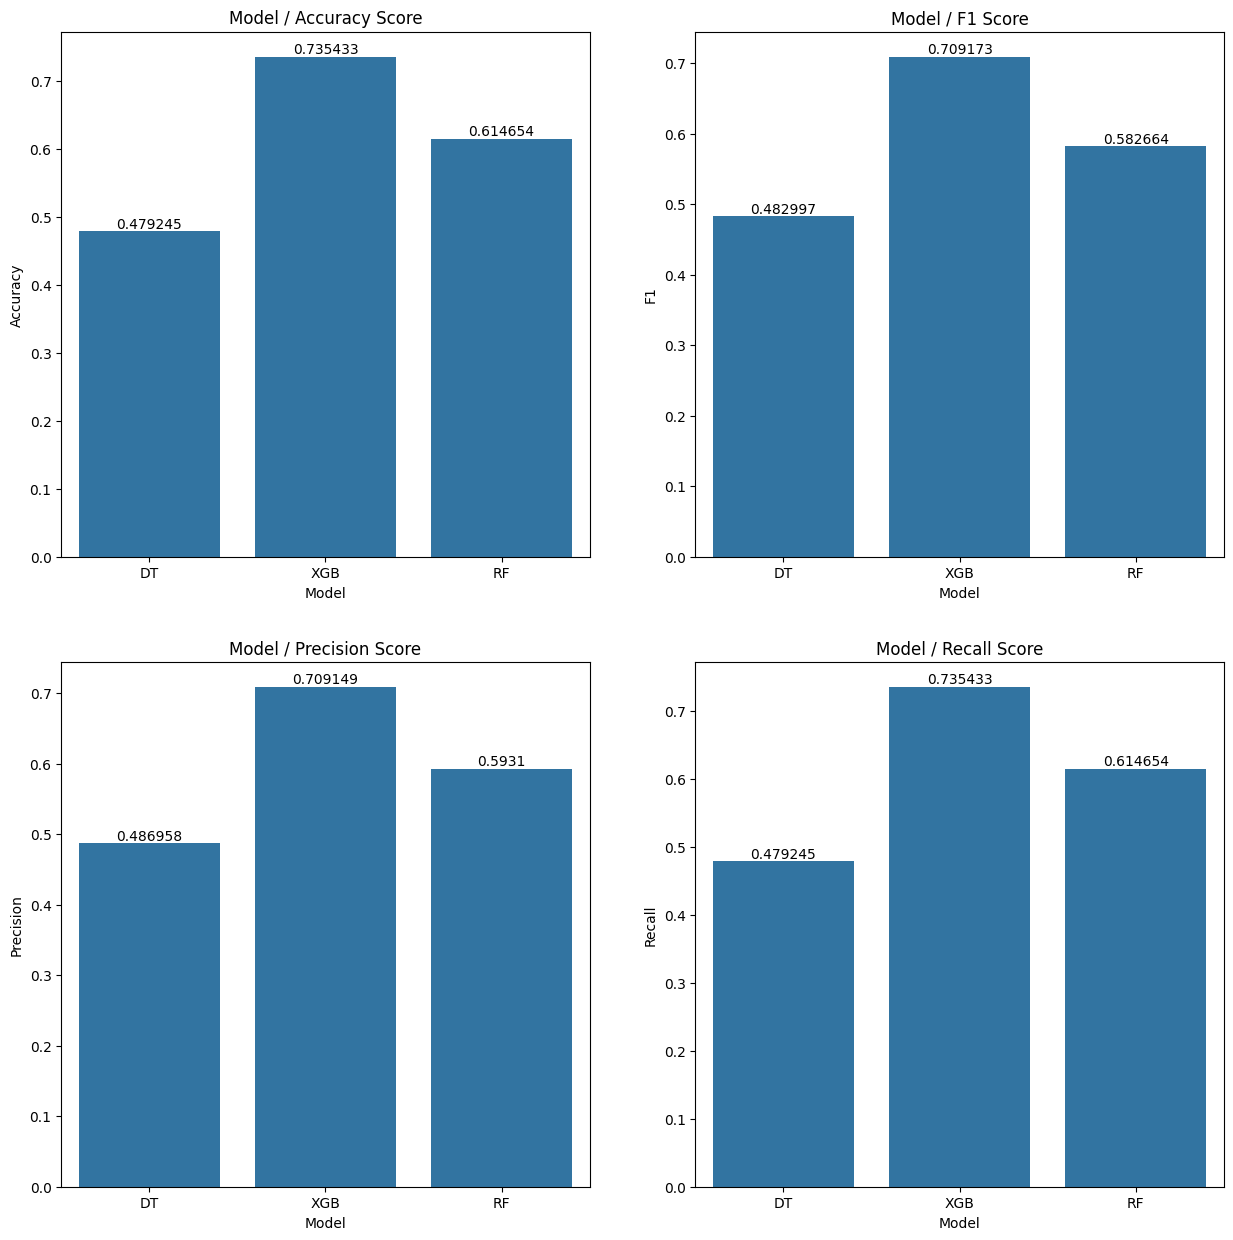

In [16]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
ax = sns.barplot(data=result_df, x="Model", y="Accuracy")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Accuracy Score")

plt.subplot(222)
ax = sns.barplot(data=result_df, x="Model", y="F1")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / F1 Score")

plt.subplot(223)
ax = sns.barplot(data=result_df, x="Model", y="Precision")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Precision Score")

plt.subplot(224)
ax = sns.barplot(data=result_df, x="Model", y="Recall")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Recall Score")

plt.show()

## Using the pre processed data for classification


We must now decide how to clean and explain the relationships between the cards.

Each classification of a hand has a different relationship attached to the cards. In order for our model to pick up on these patterns we must find a way to articulate it.

- For pairs, sets, and quads (2,3, and 4 of a kind) we must show the common occurrences in the hand.
- For straights we must show the difference between the cards in an ascending order.
- For flushes we must show the common occurrences in the suits of the hand.

In order to do this we must assign some helper functions to help clean up the data.

#### TODO:// I have put a simple helper function here, please add some more functions that will give more robust results.


In [17]:
# TODO:// Add a helper function
"""Helper class"""
import numpy as np


def add_unique_count(df):
    """The helper function is the add_unique_count function.
    This function accepts a DataFrame which is then broken into the suits.
    Then a lambda function is applied to each of the rows to check and see
    how many unique suits are in the hand.
    This helps for checking a flush condition or not. A flush will always have
    a unique count of "1" because all cards must be of the same suit.
    """
    tmp_suit = df[["S1", "S2", "S3", "S4", "S5"]]
    df["unique_suit"] = tmp_suit.apply(lambda s: len(np.unique(s)), axis=1)
    return df


def pre_process_data(data):
    """First, we have to clean up the data to prepare to calculate the
    relationships mentioned above. Here we are taking the data splitting
    it up based on card and suit. We will then sort the values before
    combining it back into one DataFrame and passing onto the next helper
    function that will add relationships to the data frame.
    """
    df = data.copy()
    cards = df[["C1", "C2", "C3", "C4", "C5"]]
    suits = df[["S1", "S2", "S3", "S4", "S5"]]
    cards.values.sort()
    suits.values.sort()
    df[["C1", "C2", "C3", "C4", "C5"]] = cards
    df[["S1", "S2", "S3", "S4", "S5"]] = suits
    df = df[["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5"]]

    df = add_unique_count(df)
    return df

After preprocessing the data save it in `content/data/processed_data/X_train_pre.csv` so that you can directly use the preprocessed data rather than wasting time again do it.


NOTE: This step will take some time to complete. Please be patient and check after some time.


In [18]:
X_train_pre = pre_process_data(X_train)
X_train_pre.to_csv(f"{data_path}/processed_data/X_train_pre.csv")
X_train_pre = pd.read_csv(f"{data_path}/processed_data/X_train_pre.csv")
X_train_pre.head(5)

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,0,1,1,1,10,1,11,1,12,1,13,1
1,1,2,1,2,10,2,11,2,12,2,13,1
2,2,3,1,3,10,3,11,3,12,3,13,1
3,3,4,1,4,10,4,11,4,12,4,13,1
4,4,4,1,4,10,4,11,4,12,4,13,1


### Removing unwanted columns


In [19]:
X_train_pre.drop("Unnamed: 0", axis=1, inplace=True)

X_train_pre.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,1,1,1,10,1,11,1,12,1,13,1
1,2,1,2,10,2,11,2,12,2,13,1
2,3,1,3,10,3,11,3,12,3,13,1
3,4,1,4,10,4,11,4,12,4,13,1
4,4,1,4,10,4,11,4,12,4,13,1


Comment the lines after preprocessing done once to save time next time by reusing the preprocessed data.


In [20]:
X_test_pre = pre_process_data(
    X_test
)  # Comment this line after preprocessing done once to save time next time
X_test_pre.to_csv(
    f"{data_path}/processed_data/X_test_pre.csv"
)  # Comment this line after preprocessing done once to save time next time
X_test_pre = pd.read_csv(f"{data_path}/processed_data/X_test_pre.csv")
X_test_pre.head(5)

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,0,1,1,1,3,1,4,2,12,2,13,2
1,1,2,2,3,5,3,5,3,11,4,12,3
2,2,1,2,1,4,3,6,3,9,4,9,3
3,3,1,1,2,4,2,6,3,13,3,13,3
4,4,1,2,2,7,2,9,3,10,4,11,4


In [21]:
X_test_pre.drop("Unnamed: 0", axis=1, inplace=True)

X_test_pre.head(5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,unique_suit
0,1,1,1,3,1,4,2,12,2,13,2
1,2,2,3,5,3,5,3,11,4,12,3
2,1,2,1,4,3,6,3,9,4,9,3
3,1,1,2,4,2,6,3,13,3,13,3
4,1,2,2,7,2,9,3,10,4,11,4


#### TODO:// Here for all the models I have used vanilla model with default parameters, you can play around with the parameters and get the best results

For parameter information please visit:

- To learn about the Decision Tree model and Random Forest model goto: https://scikit-learn.org/stable/supervised_learning.html
- To learn about the XGBoost model: https://xgboost.readthedocs.io/en/stable/


NOTE: This step will take some time to complete. Please be patient and check after some time.


In [22]:
# TODO: Add parameters
dt2 = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, criterion="gini")
dt_log2 = get_model_log(dt2, X_train_pre, y_train, X_test_pre, y_test)
dt_log2

,Accuracy,F1,Precision,Recall
0,0.973967,0.973674,0.973742,0.973967


In [23]:
xgb2 = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=6)
xgb_log2 = get_model_log(xgb2, X_train_pre, y_train, X_test_pre, y_test)
xgb_log2

,Accuracy,F1,Precision,Recall
0,0.98718,0.986188,0.986488,0.98718


In [24]:
rf2 = RandomForestClassifier(n_estimators=100, criterion="gini")
rf_log2 = get_model_log(rf2, X_train_pre, y_train, X_test_pre, y_test)
rf_log2

,Accuracy,F1,Precision,Recall
0,0.936418,0.927979,0.934328,0.936418


# Results


In [25]:
result_df = pd.DataFrame(
    {
        "Model": ["DT", "XGB", "RF", "DT2", "XGB2", "RF2"],
        "Accuracy": [
            dt_log["Accuracy"].mean(),
            xgb_log["Accuracy"].mean(),
            rf_log["Accuracy"].mean(),
            dt_log2["Accuracy"].mean(),
            xgb_log2["Accuracy"].mean(),
            rf_log2["Accuracy"].mean(),
        ],
        "F1": [
            dt_log["F1"].mean(),
            xgb_log["F1"].mean(),
            rf_log["F1"].mean(),
            dt_log2["F1"].mean(),
            xgb_log2["F1"].mean(),
            rf_log2["F1"].mean(),
        ],
        "Precision": [
            dt_log["Precision"].mean(),
            xgb_log["Precision"].mean(),
            rf_log["Precision"].mean(),
            dt_log2["Precision"].mean(),
            xgb_log2["Precision"].mean(),
            rf_log2["Precision"].mean(),
        ],
        "Recall": [
            dt_log["Recall"].mean(),
            xgb_log["Recall"].mean(),
            rf_log["Recall"].mean(),
            dt_log2["Recall"].mean(),
            xgb_log2["Recall"].mean(),
            rf_log2["Recall"].mean(),
        ],
    }
)

result_df.head(8)

,Model,Accuracy,F1,Precision,Recall
0,DT,0.479245,0.482997,0.486958,0.479245
1,XGB,0.735433,0.709173,0.709149,0.735433
2,RF,0.614654,0.582664,0.593100,0.614654
3,DT2,0.973967,0.973674,0.973742,0.973967
4,XGB2,0.987180,0.986188,0.986488,0.987180
5,RF2,0.936418,0.927979,0.934328,0.936418


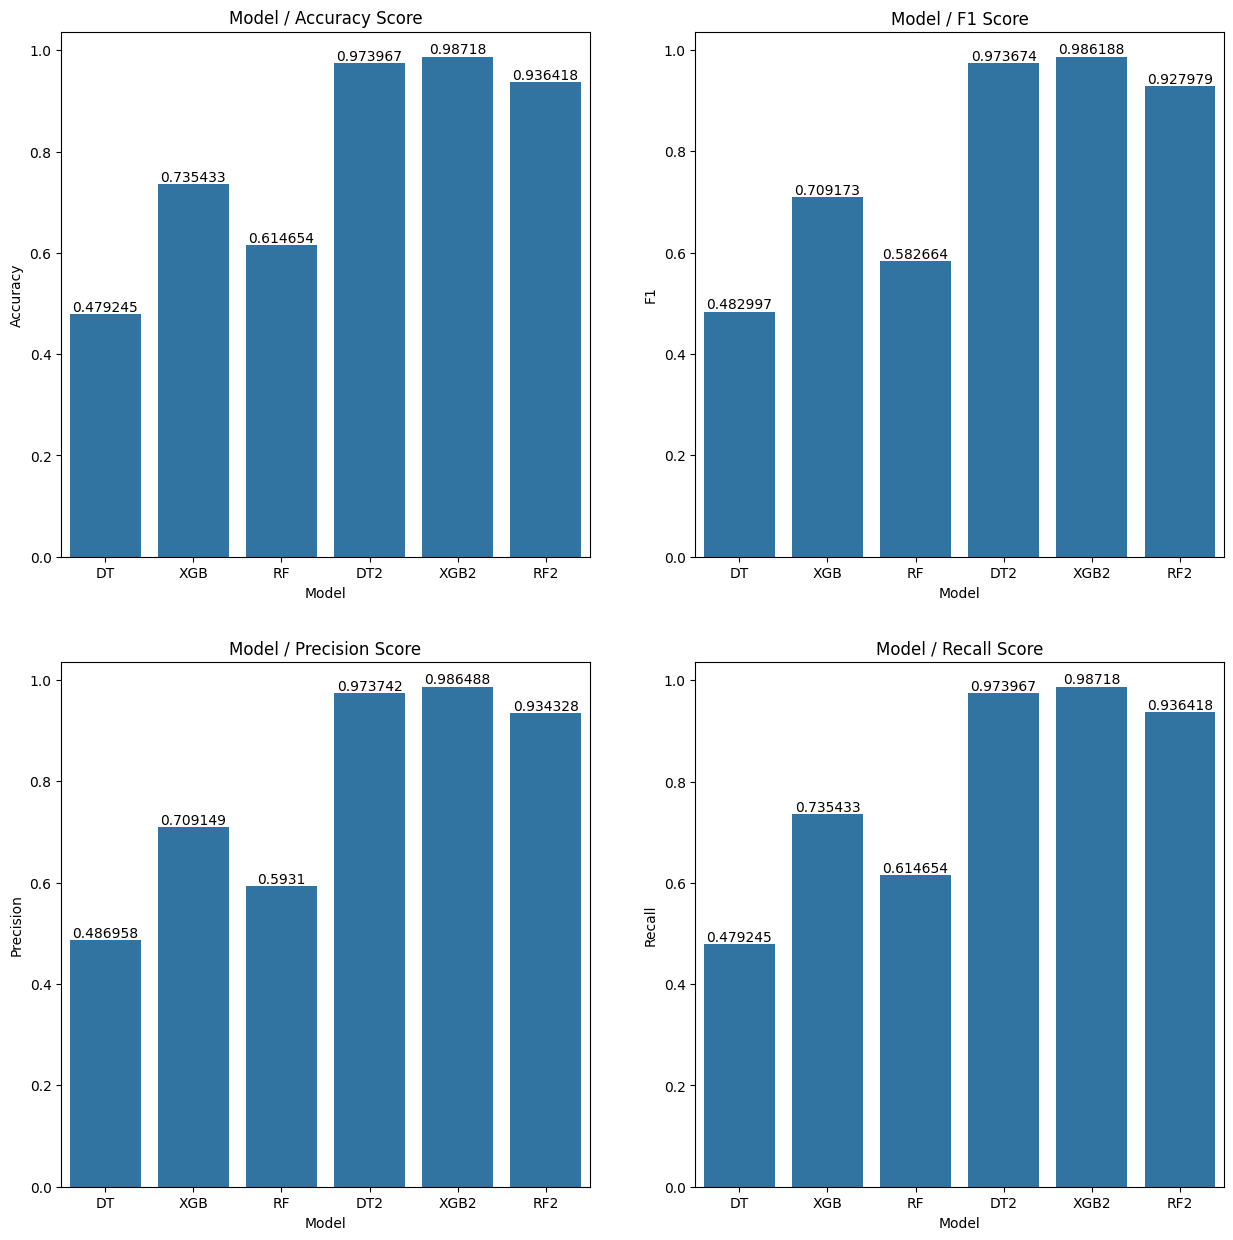

In [26]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
ax = sns.barplot(data=result_df, x="Model", y="Accuracy")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Accuracy Score")

plt.subplot(222)
ax = sns.barplot(data=result_df, x="Model", y="F1")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / F1 Score")

plt.subplot(223)
ax = sns.barplot(data=result_df, x="Model", y="Precision")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Precision Score")

plt.subplot(224)
ax = sns.barplot(data=result_df, x="Model", y="Recall")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Recall Score")

plt.show()

### Save the model


Save the model and change your team name.


In [27]:
import pickle

model_path = f"{root}/model/saved_model_teamACN.pkl"

with open(model_path, "wb") as file:
    pickle.dump(xgb2, file)

### Load the model and test it


Method to load the model and model_input (list): A list of numerical values representing the poker hand features.


In [28]:
def get_best_hand(model_input, model_file_path=f"{root}/model/saved_model_teamACN.pkl"):
    """
    Predicts the best poker hand category for a given set of model inputs using a pre-trained model.

    Parameters:
    - model_input (list): A list of numerical values representing the poker hand features.
    - model_file_path (str, optional): The file path to the pickled model file. Default is the path
      to the pre-trained model file.

    Returns:
    int: The predicted poker hand category.

    Raises:
    None
    """

    # Load the model from the pickled file
    with open(model_file_path, "rb") as file:
        loaded_model = pickle.load(file)

    # Now 'loaded_model' contains the model loaded from the pickled file
    column_names = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5"]

    df_model_input = pd.DataFrame([model_input], columns=column_names)

    x = pre_process_data(df_model_input)
    y_pred = loaded_model.predict(x)
    return y_pred

Create model input if the cards are in the form like `["CK", "C6","C7", "C8", "C9"]` to model recognisable format `` .


In [29]:
def get_model_input(cards) -> list:
    """
    Converts a list of poker cards into a numerical representation based on suit and rank.

    Parameters:
    - cards (list of str): A list of strings representing poker cards (e.g., ['H4', 'DQ']).

    Returns:
    list: A list of numerical values representing the poker cards based on suit and rank.

    Raises:
    None
    """
    suit_mapping = {"H": 1, "S": 2, "D": 3, "C": 4}
    rank_mapping = {
        "A": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "5": 5,
        "6": 6,
        "7": 7,
        "8": 8,
        "9": 9,
        "T": 10,
        "J": 11,
        "Q": 12,
        "K": 13,
    }

    # Combine dictionaries using the update method
    char_mapping = {}
    char_mapping.update(suit_mapping)
    char_mapping.update(rank_mapping)

    model_input = []

    for card in cards:
        for char in list(card):
            model_input.append(char_mapping[char])

    return model_input

### Model output

Using the methods above we can predict the outcome of the best hand in cards.


In [32]:
cards = ["CK", "C6", "C7", "C8", "C9"]
model_input = get_model_input(cards)
print(f"Model Input for {cards}: {model_input}")
model_output = get_best_hand(model_input, model_path)
print(f"Best hand: {model_output[0]}")

Model Input for ['CK', 'C6', 'C7', 'C8', 'C9']: [4, 13, 4, 6, 4, 7, 4, 8, 4, 9]
Best hand: 5


# Conclusion

As you can see XGB have at least 98% accuracy in it's prediction, so I choose to save this model for future use.

Given the results, we can conclude that we can accurately predict the given poker hand. The next steps would be adding this model to create the strategy for fold rounds.
